In [92]:
%reset -f
import numpy as np
from landlab import RasterModelGrid
from landlab.components import OverlandFlow, FlowAccumulator, SpatialPrecipitationDistribution
from landlab.plot.imshow import imshow_grid, imshow_grid_at_node
from landlab.io.esri_ascii import read_esri_ascii
from matplotlib import animation
import matplotlib.pyplot as plt

import matplotlib.colors as mcolors
colors = [(0,0.2,1,i) for i in np.linspace(0,1,3)]
cmap = mcolors.LinearSegmentedColormap.from_list('mycmap', colors, N=10)

from PIL import Image, ImageDraw

In [93]:
# Edits Franz
# ----------------------

import os
from landlab.io.esri_ascii import write_esri_ascii
import shutil


In [94]:
# Initial conditions
run_time = 500  # duration of run, (s)
h_init = 0.1  # initial thin layer of water (m)
n = 0.01  # roughness coefficient, (s/m^(1/3))
g = 9.8  # gravity (m/s^2)
alpha = 0.7  # time-step factor (nondimensional; from Bates et al., 2010)
u = 0.4  # constant velocity (m/s, de Almeida et al., 2012)
run_time_slices = np.arange(0,run_time+1,50) #show every 20th 
elapsed_time = 1.0 #Elapsed time starts at 1 second. This prevents errors when setting our boundary conditions.

In [95]:
# Edits Franz
# ----------------------

# time scale for rainfall events. To be adjusted. I am cheating with units... 
nb_years = 5
# Factor to scale rainfall values from the module SpatialPrecipitationDistribution (may generate very
# small amounts of rainfall, which renders poorly...)
rainfall_scaling = 1000.

# Folder for runoff results 
dir_runoff = './runoff_results'
# Folder for rainfall data
dir_rainfall = './rainfall_series'

# Overwrite or create directory for rainfall data
if os.path.exists(dir_runoff):
    shutil.rmtree(dir_runoff)
os.makedirs(dir_runoff)

# Overwrite or create directory for rainfall data
if os.path.exists(dir_rainfall):
    shutil.rmtree(dir_rainfall)
os.makedirs(dir_rainfall)

In [96]:
#Define grid
# here we use an arbitrary, very small, "real" catchment
fname = '../data/hugo_site.asc'
rmg, z = read_esri_ascii(fname, name='topographic__elevation')
rmg.status_at_node[rmg.nodes_at_right_edge] = rmg.BC_NODE_IS_FIXED_VALUE
rmg.status_at_node[np.isclose(z, -9999.)] = rmg.BC_NODE_IS_CLOSED

In [97]:
#Define outlet
rmg_outlet_node = 2051 #node
outlet_node_to_sample = 2050
outlet_link_to_sample = rmg.links_at_node[outlet_node_to_sample][3]

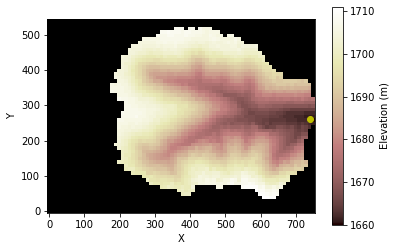

In [98]:
#Plot topography and outlet
plt.figure()
imshow_grid_at_node(rmg, z, colorbar_label='Elevation (m)')
plt.plot(rmg.node_x[outlet_node_to_sample], rmg.node_y[outlet_node_to_sample], "yo")

plt.show()

In [99]:
### Edits Franz
# ----------------------

# Important note: SpatialPrecipitationDistribution generate rainfall events per years over
# an input grid. I guess the number of events also depends on the size of the catchment/grid
# So we need to set a nb_years as input for number_of_years. And scale the storm events over run_time.
# Let's consider rainfall instantaneous.

# Create time series of rainfall events (output is in mm/h)
rain = SpatialPrecipitationDistribution(rmg,number_of_years = nb_years)
np.random.seed(26)  # arbitrary to get a cool-looking storm out every tim

# Container for rainfall duration
storm_t_all = []
interstorm_t_all = []

# get the storm simulator to provide a storm
# Variables required to generate rainfall datasets
i = 0
max_rainfall = []
for (storm_t, interstorm_t) in rain.yield_storms():  # storm lengths in hrs
    i += 1
    rmg.at_node['rainfall__flux'] *= 0.001  # because the rainfall comes out in mm/h
    rmg.at_node['rainfall__flux'] *= rainfall_scaling  # to make the storm heavier and more interesting!

    # Save rainfall data to ascii file
    write_esri_ascii('./'+ dir_rainfall +'/rainfall_'+ str(i) + '.asc', rmg, 'rainfall__flux', clobber=True)
    
    # Save duration of storm and non-storm periods
    storm_t_all.append(storm_t)
    interstorm_t_all.append(interstorm_t)
    
    # Store max rainfall value
    max_rainfall.append(max(rmg.at_node['rainfall__flux']))

storm_ids = np.array(range(len(storm_t_all))) + 1

# Get moment of storms (initially in hours, to be rescaled over run_time 
# -> cheating to get some results...)
days_storms = (np.array(interstorm_t_all)/24)
scaled_days_storms = (days_storms * (run_time / (nb_years*365))).round()
scaled_days_storms = scaled_days_storms.cumsum()
# Set first storm a time = 1
scaled_days_storms = scaled_days_storms - scaled_days_storms[0] + 1

print(scaled_days_storms)

# print(scaled_days_storms.sum())
# print(scaled_days_storms)
# print((np.array(storm_t_all).sum()+np.array(interstorm_t_all).sum())/24/nb_years)
# print(len(interstorm_t_all))
# print(storm_id)


[   1.   59.  101.  101.  159.  201.  259.  301.  359.  401.  459.]


In [100]:
# #Set initial water depth values
# rmg.at_node["surface_water__depth"] = np.zeros(rmg.number_of_nodes)
# #Pointer to water depth
# h = rmg.at_node['surface_water__depth']
# bools = (rmg.node_y > 100) * (rmg.node_y < 450) * (rmg.node_x < 400) * (rmg.node_x > 350)
# h[bools] = 2

## Set inital discharge
rmg.at_node["surface_water__discharge"] = np.zeros(rmg.number_of_nodes)


In [101]:
# Edits Franz 
# ----------------------

#Set initial water depth values and rainfall flux values
rmg.at_node["surface_water__depth"] = np.zeros(rmg.number_of_nodes)
rmg.at_node.pop('rainfall__flux')
# print(rmg.at_node.keys())

# Read first rainfall data
q_rain = read_esri_ascii('./rainfall_series/rainfall_1.asc', grid=rmg, name='rainfall__flux')
# Update id for rainfall
rainfall_id = 1

# Update surface water depth with rainfall data
rmg.at_node['surface_water__depth'].fill(1.e-12)  # a veneer of water stabilises the model
rmg.at_node['surface_water__depth'] += rmg.at_node['rainfall__flux'] # storm_t_all[0]


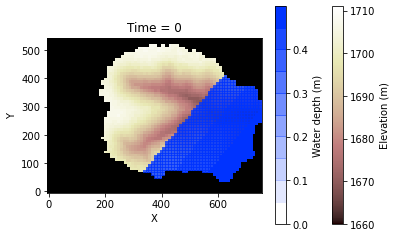

In [102]:
fig1 = plt.figure()
imshow_grid(rmg,'topographic__elevation',colorbar_label='Elevation (m)')
imshow_grid(rmg,'surface_water__depth',cmap=cmap,colorbar_label='Water depth (m)')
plt.title(f'Time = 0')
plt.show()
fig1.savefig(dir_runoff + f"/runoff_0.jpeg")# print(rmg.at_node.keys())

In [103]:
#Call overland flow model
of = OverlandFlow(rmg, steep_slopes=True)
of.run_one_step()

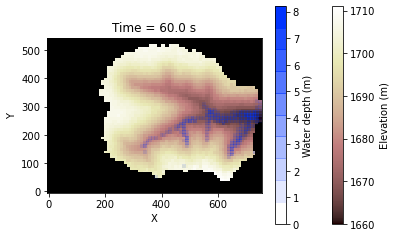

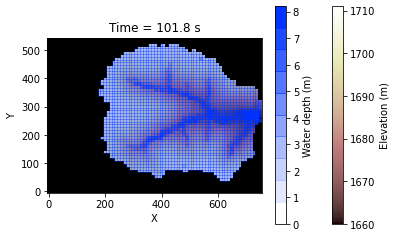

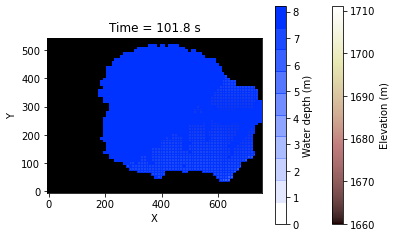

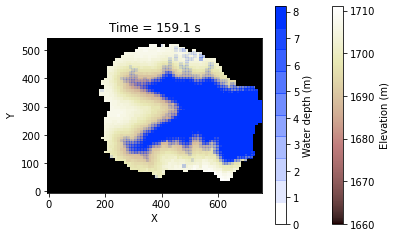

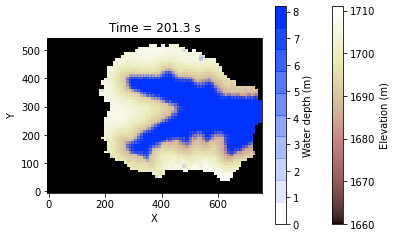

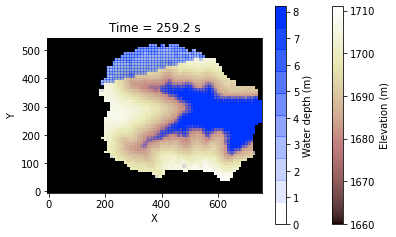

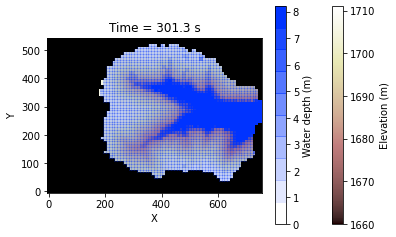

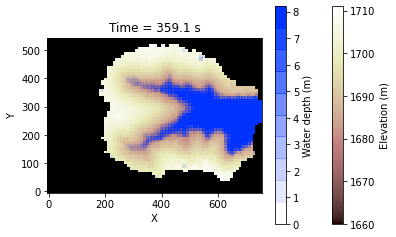

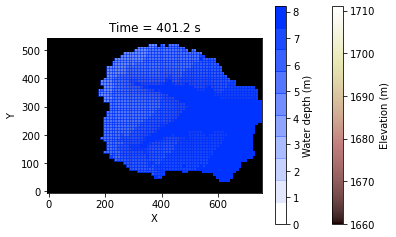

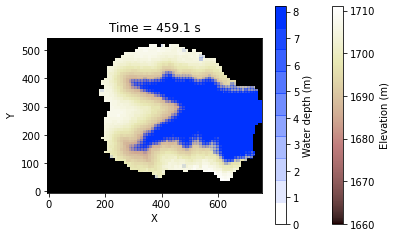

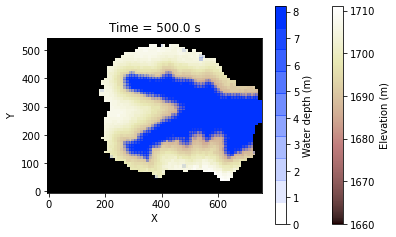

In [104]:
# Edits Franz 
# ----------------------

# look at hydorgraph at outlet 
hydrograph_time = []
discharge_at_outlet = []
height_at_outlet = []

#Run model
# for t in run_time_slices:
# Tweak time steps
time_steps = np.append(scaled_days_storms,[500])[1:]
for t in time_steps:
    #Run until next time to plot    
    while elapsed_time < t: 
        # First, we calculate our time step.
        dt = of.calc_time_step()
        # Now, we can generate overland flow.
        of.overland_flow()
        # Increased elapsed time
        elapsed_time += dt
        
        ## Append time and discharge and water depth to their lists to save data and for plotting.
        hydrograph_time.append(elapsed_time) 
        q = rmg.at_link["surface_water__discharge"]
        discharge_at_outlet.append(np.abs(q[outlet_link_to_sample]) * rmg.dx)
        ht = rmg.at_node['surface_water__depth']
        height_at_outlet.append(np.abs(ht[outlet_node_to_sample]))
    
    # Update rainfall dataset id
    rainfall_id += 1
    rainfall_name = 'rainfall__flux_' + str(rainfall_id)
    # print(rainfall_id)
    
    # Avoid last time step
    if rainfall_id <= len(scaled_days_storms):
        # Read rainfall data
        # rmg.at_node.pop('rainfall__flux')
        q_rain = read_esri_ascii('./rainfall_series/rainfall_' + str(rainfall_id) + '.asc', grid=rmg, name=rainfall_name)
        # Add rainfall event to water depth
        rmg.at_node['surface_water__depth'] += rmg.at_node[rainfall_name]
    
    # Plot water depth for current time step
    fig=plt.figure()
    imshow_grid(rmg,'topographic__elevation',colorbar_label='Elevation (m)')
    imshow_grid(rmg,'surface_water__depth',limits=(0,np.array(max_rainfall).max()),cmap=cmap,colorbar_label='Water depth (m)')
    plt.title(f'Time = {round(elapsed_time,1)} s')
    plt.show()
    fig.savefig(dir_runoff + f"/runoff_{round(elapsed_time,1)}.jpeg")
        

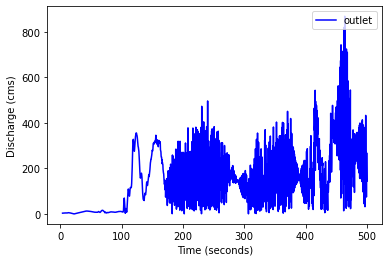

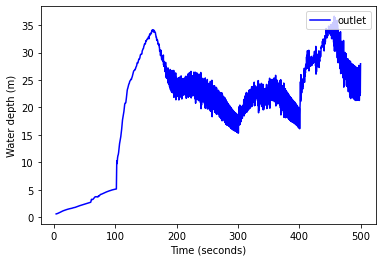

In [105]:
## Plotting hydrographs and discharge
fig=plt.figure(2)
plt.plot(hydrograph_time, discharge_at_outlet, "b-", label="outlet")

plt.ylabel("Discharge (cms)")
plt.xlabel("Time (seconds)")
plt.legend(loc="upper right")
fig.savefig(dir_runoff + f"/runoff_discharge.jpeg")

fig=plt.figure(3)
plt.plot(hydrograph_time, height_at_outlet, "b-", label="outlet")
plt.ylabel("Water depth (m)")
plt.xlabel("Time (seconds)")
plt.legend(loc="upper right")
fig.savefig(dir_runoff + f"/runoff_waterdepth.jpeg")